In [9]:
print("Importing misc libraries")
import sys
import os
import torch
#import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import datetime

print("Updating sys.path")
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
models_path = Path.cwd().parent
if str(models_path) not in sys.path:
    sys.path.append(str(models_path))
    
print("Importing torch libraries")
from torch.utils.data import DataLoader
import multiprocessing
from torchvision.transforms import ToTensor
import torch
from torch.optim import Adam
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
    
print("Importing unet lib")
import importlib
import unet.Unet as u
importlib.reload(u)

print("Importing dataset+loss lib")
import dataset.IntersectionDataset
importlib.reload(dataset.IntersectionDataset)
from dataset.IntersectionDataset import IntersectionDataset, IntersectionDataset2, IntersectionDatasetClasses, custom_collate_fn
import loss.loss_lib as ll
importlib.reload(ll)

dataset_dir = "../../dataset/dataset/train"
img_transform = ToTensor()
path_transform = ToTensor()
dataset_train = IntersectionDatasetClasses(root_dir=dataset_dir, 
                                    transform=img_transform,
                                    path_transform=path_transform)

dataset_dir = "../../dataset/dataset/test"
img_transform = ToTensor()
path_transform = ToTensor()
dataset_test = IntersectionDatasetClasses(root_dir=dataset_dir,
                                   transform=img_transform,
                                   path_transform=path_transform)
print(len(dataset_train))
print(len(dataset_test))

num_workers = multiprocessing.cpu_count()
b = 4

train_dataloader = DataLoader(dataset_train, batch_size=b, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(dataset_test, batch_size=b, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True, collate_fn=custom_collate_fn)

Importing misc libraries
Updating sys.path
Importing torch libraries
Importing unet lib
Importing dataset+loss lib
904
32


In [4]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) and m.kernel_size == (1, 1):
        nn.init.normal_(m.weight, mean=0, std=0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    else:
        pass

In [7]:
try: 
    del(model)
except NameError:
    pass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = u.UNet(n_channels=3, n_classes=5).to(device) # background, left, right, ahead, stacked
model.apply(init_weights)

try:
    del(optimizer)
except NameError:
    pass
optimizer = Adam(model.parameters(), lr=1e-4)

try:
    del(scheduler)
except NameError:
    pass
#scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2, eta_min=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6)

try:
    del(scaler)
except NameError:
    pass
scaler = GradScaler(device=device)

class_counts = torch.tensor([152000, 2000, 2000, 2000, 2000], dtype=torch.float)
weights = 1.0 / class_counts
weights = weights / weights.sum()
lce = torch.nn.CrossEntropyLoss(weight=weights.to(device))
lce = lce.to(device)
lcm = ll.CmapLoss().to(device)
lbc = ll.BCELoss().to(device)

In [ ]:
from tqdm.notebook import tqdm

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

n_epochs = 500
alpha = 0.5
epochs = tqdm(range(n_epochs), desc="Training", unit=" epoch")

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

for epoch in epochs:
    model.train()
    running_train_loss = 0.0
    running_train_correct = 0
    running_train_total = 0
    
    batches = tqdm(train_dataloader, desc="Batches", unit=" batch", leave=False)
    
    for batch in batches:
        satellite = batch["satellite"].to(device, non_blocking=True)
        class_labels = batch["class_labels"].to(device, non_blocking=True)
        #cold_maps = batch["paths"]
        #paths_c = [torch.as_tensor(p["cold_map"]).to(device) for p in cold_maps[0]]
        
        class_labels = class_labels.squeeze(1)
        
        optimizer.zero_grad()
        
        with autocast("cuda"):
            output = model(satellite)
            # cnt = 0
            # L_cmaps = []
            # for c in paths_c:
            #     cnt += 1
            #     L_cmaps.append(lcm(torch.sigmoid(output), c))
            # L_cmap = sum(L_cmaps) / cnt
            L_ce = lce(output, class_labels)
            
            #loss = alpha * L_ce + (1 - alpha) * L_cmap
            loss = L_ce
            
        scaled_loss = scaler.scale(loss)
        scaled_loss.backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_train_loss += loss.item()
        
        p = torch.argmax(output, dim=1)
        running_train_correct += (p == class_labels).sum().item()
        running_train_total += class_labels.size(0)
        
        batches.set_postfix({"Loss": loss.item()})
        
        
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracy = running_train_correct / running_train_total
    train_accuracies.append(train_accuracy)
    
    model.eval()
    running_test_loss = 0.0
    running_test_correct = 0
    running_test_total = 0
    
    test_batches = tqdm(test_dataloader, desc="Batches", unit=" batch", leave=False)
    with torch.no_grad():
        for batch in test_batches:
            satellite = batch["satellite"].to(device, non_blocking=True)
            class_labels = batch["class_labels"].to(device, non_blocking=True)
            #cold_maps = batch["paths"]
            #paths_c = [torch.as_tensor(p["cold_map"]).to(device) for p in cold_maps[0]]
            #path_line = batch["paths"]
            
            class_labels = class_labels.squeeze(1)
            
            with autocast("cuda"):
                output = model(satellite)
                # cnt = 0
                # L_cmaps = []
                # for c in paths_c:
                #     cnt += 1
                #     L_cmaps.append(lcm(torch.sigmoid(output), c))
                # L_cmap = sum(L_cmaps) / cnt
                L_ce = lce(output, class_labels)
                
                #loss = alpha * L_ce + (1 - alpha) * L_cmap
                loss = L_ce
            
            running_test_loss += loss.item()
            
            p = torch.argmax(output, dim=1)
            running_test_correct += (p == class_labels).sum().item()
            running_test_total += class_labels.size(0)
            
            test_batches.set_postfix({"Loss": loss.item()})
            
    test_batches.close()
            
    avg_test_loss = running_test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)
    
    test_accuracy = running_test_correct / running_test_total
    test_accuracies.append(test_accuracy)
    
    scheduler.step(avg_test_loss)  
    
    if (epoch + 1) % 50 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies,
        }
        #os.makedirs('./ckpt', exist_ok=True)
        date = datetime.datetime.now().strftime("%m_%d_")
        torch.save(checkpoint, f'./ckpt/{date}ce_cmap_checkpoint_epoch_{epoch + 1}_5classes_plateauLR.pth')
        
    epochs.set_postfix({"Train Loss": avg_train_loss, "Test Loss": avg_test_loss, "Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy})
    batches.close()
    
epochs.close()

    
#torch.save(model.state_dict(), "model_200e_ce_new_dataset_3class.pth")

Training:   0%|          | 0/500 [00:00<?, ? epoch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

Batches:   0%|          | 0/226 [00:00<?, ? batch/s]

Batches:   0%|          | 0/8 [00:00<?, ? batch/s]

In [13]:
date = datetime.datetime.now().strftime("%m_%d_")
date

'03_27_'

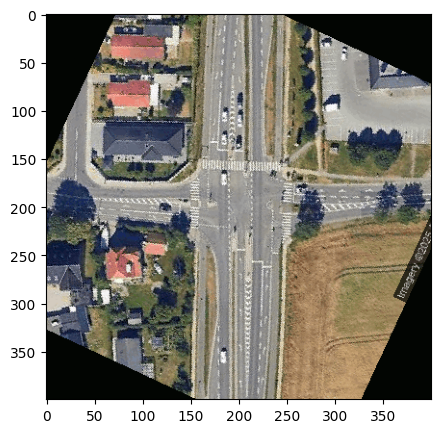

In [32]:
for batch in test_dataloader:
    paths = batch["paths"]
    paths_c = [torch.as_tensor(p["cold_map"]).to(device) for p in paths[0]]
    
    satellite = batch["satellite"].to(device, non_blocking=True)
    output = model(satellite)
    
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(satellite[0].cpu().permute(1, 2, 0))
    plt.show()
    break

In [5]:
for batch in test_dataloader:
    satellite = batch["satellite"].to(device, non_blocking=True)
    class_labels = batch["class_labels"].to(device, non_blocking=True)
    cold_maps = batch["paths"]
    paths_c = [torch.as_tensor(p["cold_map"]).to(device) for p in cold_maps[0]]
    break

In [6]:
output = model(satellite)

In [33]:
torch.argmax(output, dim=1).shape

torch.Size([4, 400, 400])

In [9]:
o = (torch.argmax(output, dim=1)[0] > 0).float().requires_grad_(True)
cnt = 0
L_cmaps = []
for c in paths_c:
    cnt += 1
    # Expand dimensions of `1 - c` to match `output`
    c_expanded = (1 - c).unsqueeze(0).unsqueeze(0).expand(output.shape[0], output.shape[1], -1, -1)
    L_cmap = lbc(c_expanded, output)
    L_cmaps.append(L_cmap)
L_cmap = sum(L_cmaps) / cnt

L_cmap


tensor(0.6928, device='cuda:0', grad_fn=<DivBackward0>)

In [49]:
output = model(satellite)

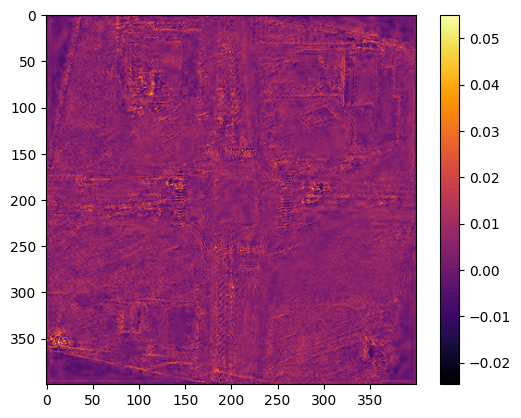

In [7]:
# Select the first batch and the first channel for visualization
output_image = output[0, 0, :, :].cpu().detach().numpy()

plt.imshow(output_image, cmap="inferno")
plt.colorbar()

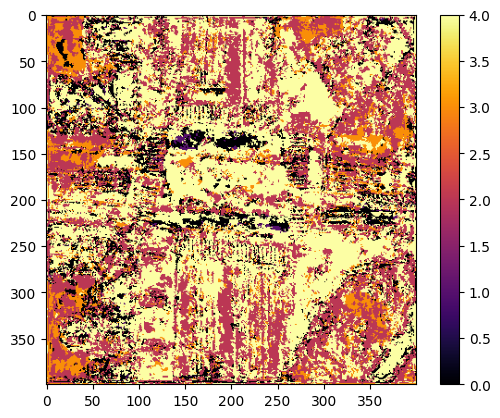

In [ ]:
o_arg = torch.argmax(output, dim=1)
output_image_sig = o_arg[0, :, :].cpu().detach().numpy()

plt.imshow(output_image_sig, cmap="inferno")
plt.colorbar()

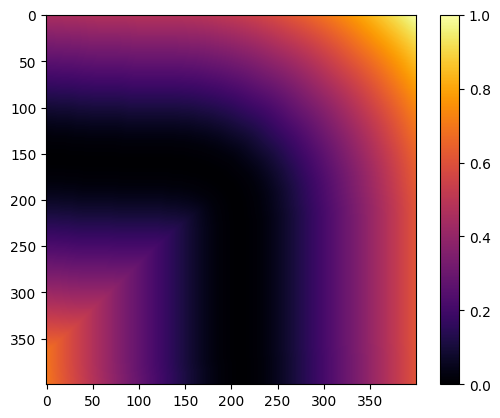

In [41]:
path_line = batch["paths"][0][1]["cold_map"]

plt.imshow(path_line, cmap="inferno")
plt.colorbar()